<a href="https://colab.research.google.com/github/claudio1975/Climate_Risk_Modelling_with_LLMs/blob/main/single_step/with_augmentation/Flood_pred_deaths_direct_work_single_step_aug_v_4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [1]:
! pip install shap &> /dev/null

In [2]:
! pip install optuna &> /dev/null

In [3]:
# utils packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import datetime
import scipy
import scipy.stats as stats
import statsmodels
import sklearn
import lightgbm
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import radians, sin, cos, sqrt, atan2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import randint
import optuna


# packages for prediction and other utils functions
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# to evaluate models
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import make_scorer
import shap

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
np.__version__

'1.25.2'

In [5]:
pd.__version__

'2.0.3'

In [6]:
matplotlib.__version__

'3.7.1'

In [7]:
sns.__version__

'0.13.1'

In [8]:
scipy.__version__

'1.11.4'

In [9]:
statsmodels.__version__

'0.14.2'

In [10]:
sklearn.__version__

'1.2.2'

In [11]:
optuna.__version__

'3.6.1'

In [12]:
shap.__version__

'0.45.1'

In [13]:
lightgbm.__version__

'4.1.0'

### Upload data set

In [14]:
df=pd.read_csv('./flood_dataset_fe4.csv',index_col=0)

### Handling Date Time format

In [15]:
# Trasform BEGIN_DATE_TIME and END_DATE_TIME in datetime format
df["BEGIN_DATE_TIME"] = pd.to_datetime(df["BEGIN_DATE_TIME"], format="%d-%b-%y %H:%M:%S")
df["END_DATE_TIME"] = pd.to_datetime(df["END_DATE_TIME"], format="%d-%b-%y %H:%M:%S")

In [16]:
# Create index
df.index = pd.to_datetime(df.BEGIN_DATE_TIME)
df.index.names = ['Date']
# Sort DataFrame by date column in descending order
df.sort_values(by='Date', ascending = True, inplace = True)
# Sanity check: data span.
df.index.min(), df.index.max()

(Timestamp('2006-10-02 14:00:00'), Timestamp('2022-12-31 23:00:00'))

### Have a brief look of the data set

In [17]:
df.shape

(38398, 53)

In [18]:
df.columns

Index(['EVENT_ID', 'BEGIN_DATE_TIME', 'END_DATE_TIME', 'STATE', 'STATE_FIPS',
       'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'FLOOD_CAUSE', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_RANGE', 'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON',
       'END_LAT', 'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
       'predicted_sentiment_gpt', 'embed_episod_gpt0', 'embed_episod_gpt1',
       'embed_episod_gpt2', 'embed_episod_gpt3', 'embed_episod_gpt4',
       'embed_episod_gpt5', 'embed_episod_gpt6', 'embed_episod_gpt7',
       'embed_episod_gpt8', 'embed_episod_gpt9', 'embed_event_gpt0',
       'embed_event_gpt1', 'embed_event_gpt2', 'embed_event_gpt3',
       'embed_event_gpt4', 'embed_event_gpt5', 'embed_event_gpt6',
       'embed_event_gpt7', 'embed_event_gpt8', 'embed_event_gpt9',
       

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38398 entries, 2006-10-02 14:00:00 to 2022-12-31 23:00:00
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   EVENT_ID                 38398 non-null  int64         
 1   BEGIN_DATE_TIME          38398 non-null  datetime64[ns]
 2   END_DATE_TIME            38398 non-null  datetime64[ns]
 3   STATE                    38398 non-null  object        
 4   STATE_FIPS               38398 non-null  float64       
 5   EVENT_TYPE               38398 non-null  object        
 6   CZ_TYPE                  38398 non-null  object        
 7   CZ_FIPS                  38398 non-null  int64         
 8   CZ_NAME                  38398 non-null  object        
 9   WFO                      38398 non-null  object        
 10  CZ_TIMEZONE              38398 non-null  object        
 11  INJURIES_DIRECT          38398 non-null  int64         
 1

In [20]:
num_cols = [var for var in df.columns if df[var].dtype in ['int64','float64']]
num = df[num_cols]
num.columns

Index(['EVENT_ID', 'STATE_FIPS', 'CZ_FIPS', 'INJURIES_DIRECT',
       'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'BEGIN_RANGE', 'END_RANGE',
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'embed_episod_gpt0',
       'embed_episod_gpt1', 'embed_episod_gpt2', 'embed_episod_gpt3',
       'embed_episod_gpt4', 'embed_episod_gpt5', 'embed_episod_gpt6',
       'embed_episod_gpt7', 'embed_episod_gpt8', 'embed_episod_gpt9',
       'embed_event_gpt0', 'embed_event_gpt1', 'embed_event_gpt2',
       'embed_event_gpt3', 'embed_event_gpt4', 'embed_event_gpt5',
       'embed_event_gpt6', 'embed_event_gpt7', 'embed_event_gpt8',
       'embed_event_gpt9'],
      dtype='object')

In [21]:
obj_cols = [var for var in df.columns if df[var].dtype in ['object']]
cat = df[obj_cols]
cat.columns

Index(['STATE', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE',
       'SOURCE', 'FLOOD_CAUSE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_AZIMUTH', 'END_LOCATION', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
       'predicted_sentiment_gpt', 'predicted_risk_gpt'],
      dtype='object')

### Build features

In [22]:
# Created year, month, day, time begin/end feature
df_1 = df.copy()
df_1['YEAR_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).year
df_1['MONTH_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).month
df_1['DAY_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).day
df_1['HOUR_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).hour
df_1['YEAR_BEGIN']= df_1["YEAR_BEGIN"].astype("int64")
df_1['MONTH_BEGIN']= df_1["MONTH_BEGIN"].astype("int64")
df_1['DAY_BEGIN']= df_1["DAY_BEGIN"].astype("int64")
df_1['HOUR_BEGIN']= df_1["HOUR_BEGIN"].astype("int64")
df_1['YEAR_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).year
df_1['MONTH_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).month
df_1['DAY_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).day
df_1['HOUR_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).hour
df_1['YEAR_END']= df_1["YEAR_END"].astype("int64")
df_1['MONTH_END']= df_1["MONTH_END"].astype("int64")
df_1['DAY_END']= df_1["DAY_END"].astype("int64")
df_1['HOUR_END']= df_1["HOUR_END"].astype("int64")

In [23]:
# Calculate the difference between dates and convert it to days and hours
df_1['DAY_DURATION'] = (df_1['END_DATE_TIME'] - df_1['BEGIN_DATE_TIME']).dt.days
df_1['HOUR_DURATION'] = (df_1['END_DATE_TIME'] - df_1['BEGIN_DATE_TIME']).dt.total_seconds() / 3600

In [24]:
# Merge Origin and Destination to have a look at the round event
df_1['LOCATION_ORIGIN_DESTINATION'] = df_1['BEGIN_LOCATION']+'-'+df_1['END_LOCATION']
df_1['BEGIN_END_AZIMUTH'] = df_1['BEGIN_AZIMUTH']+'-'+df_1['END_AZIMUTH']

In [25]:
# new target features
df_1['WHOLE_INJURIES'] = df_1['INJURIES_INDIRECT'] + df_1['INJURIES_DIRECT']
df_1['WHOLE_DEATHS'] = df_1['DEATHS_INDIRECT'] + df_1['DEATHS_DIRECT']
df_1['WHOLE_DAMAGE'] = df_1['DAMAGE_CROPS'] + df_1['DAMAGE_PROPERTY']

In [26]:
# Distance of the event
def haversine_distance(row):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = radians(row['BEGIN_LAT']), radians(row['BEGIN_LON'])
    lat2, lon2 = radians(row['END_LAT']), radians(row['END_LON'])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    radius_of_earth = 6371  # Earth's radius in kilometers
    distance = radius_of_earth * c

    return distance

In [27]:
# Distance
df_1['DISTANCE'] = df_1.apply(haversine_distance, axis=1)
df_1['DISTANCE_RANGE']=df_1['END_RANGE']-df_1['BEGIN_RANGE']

In [28]:
# Drop old variables replaced by new variables
df_2=df_1.copy()
df_2 = df_2.drop(['BEGIN_LOCATION','END_LOCATION','BEGIN_AZIMUTH','END_AZIMUTH',
                  'INJURIES_INDIRECT','DEATHS_INDIRECT','DAMAGE_CROPS',
                  'END_RANGE','BEGIN_RANGE','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON'], axis=1)

### Encoding

In [29]:
df_encod=df_2.copy()

In [30]:
# encod_predicted_sentiment_gpt
encod_sentiment = {'negative':'0','positive':'1','neutral':'2'}
df_encod['predicted_sentiment_gpt'] = df_encod['predicted_sentiment_gpt'].map(encod_sentiment)
df_encod['predicted_sentiment_gpt']= df_encod['predicted_sentiment_gpt'].astype(int)
# encod_predicted_risk_gpt
encod_risk = {'high risk':'0','medium risk':'1','low risk':'2'}
df_encod['predicted_risk_gpt'] = df_encod['predicted_risk_gpt'].map(encod_risk)
df_encod['predicted_risk_gpt']= df_encod['predicted_risk_gpt'].astype(int)


In [31]:
# grouping_STATE
# '0' -> 'OTHERS'
state_group = {'NORTH CAROLINA':'1','ILLINOIS':'2','INDIANA':'3','KENTUCKY':'4','ARKANSAS':'5','TEXAS':'6','TENNESSEE':'7','MISSOURI':'8'}
df_encod['STATE'] = df_encod['STATE'].map(state_group)
df_encod['STATE'].fillna('0', inplace=True)
df_encod['STATE']= df_encod['STATE'].astype(int)


In [32]:
# grouping_CZ_NAME
# '0' -> 'OTHERS'
state_group = {'DAVIDSON':'1','BUTLER':'2','WASHINGTON':'3','FULTON':'4','KANAWHA':'5', 'JEFFERSON':'6','JOHNSTON':'7','MADISON':'8'}
df_encod['CZ_NAME'] = df_encod['CZ_NAME'].map(state_group)
df_encod['CZ_NAME'].fillna('0', inplace=True)
df_encod['CZ_NAME']= df_encod['CZ_NAME'].astype(int)


In [33]:
# grouping_WFO
# '0' -> 'OTHERS'
state_group = {'RLX':'1','PAH':'2','LMK':'3','FWD':'4','MHX':'5','TSA':'6','CTP':'7','OHX':'8'}
df_encod['WFO'] = df_encod['WFO'].map(state_group)
df_encod['WFO'].fillna('0', inplace=True)
df_encod['WFO']= df_encod['WFO'].astype(int)


In [34]:
# grouping_CZ_TIMEZONE
# '0' -> 'OTHERS'
state_group = {'CST-6':'1','PST-8':'2','MST-7':'3','EST-5':'4'}
df_encod['CZ_TIMEZONE'] = df_encod['CZ_TIMEZONE'].map(state_group)
df_encod['CZ_TIMEZONE'].fillna('0', inplace=True)
df_encod['CZ_TIMEZONE']= df_encod['CZ_TIMEZONE'].astype(int)

In [35]:
# grouping_SOURCE
# '0' -> 'OTHERS'
state_group = {'Law Enforcement':'1','Newspaper':'2','Broadcast Media':'3','Emergency Manager':'4','Trained Spotter':'5','County Official':'6','River/Stream Gage':'7','Trained Spotter':'8'}
df_encod['SOURCE'] = df_encod['SOURCE'].map(state_group)
df_encod['SOURCE'].fillna('0', inplace=True)
df_encod['SOURCE']= df_encod['SOURCE'].astype(int)

In [36]:
# grouping_FLOOD_CAUSE
# '0' -> 'OTHERS'
state_group = {'Heavy Rain':'1','Heavy Rain/Snow Melt':'2','Heavy Rain/Tropical System':'3'}
df_encod['FLOOD_CAUSE'] = df_encod['FLOOD_CAUSE'].map(state_group)
df_encod['FLOOD_CAUSE'].fillna('0', inplace=True)
df_encod['FLOOD_CAUSE']= df_encod['FLOOD_CAUSE'].astype(int)

In [37]:
# grouping_BEGIN_END_AZIMUTH
# '0' -> 'OTHERS'
state_group = {'SSW-SSW':'1','N-N':'2','W-W':'3','SSE-SSE':'4','S-S':'5'}
df_encod['BEGIN_END_AZIMUTH'] = df_encod['BEGIN_END_AZIMUTH'].map(state_group)
df_encod['BEGIN_END_AZIMUTH'].fillna('0', inplace=True)
df_encod['BEGIN_END_AZIMUTH']= df_encod['BEGIN_END_AZIMUTH'].astype(int)

In [38]:
# grouping_LOCATION_ORIGIN_DESTINATION
# '0' -> 'OTHERS'
state_group = {'RURAL HILL-HERMITAGE':'1','MOORES FERRY-MOORES FERRY':'2','SCUPPERNONG-PLYMOUTH':'3','DEODATE-BERRYSBURG':'4','PLAINS-WOODLAWN':'5','SICILY-SICILY':'6'}
df_encod['LOCATION_ORIGIN_DESTINATION'] = df_encod['LOCATION_ORIGIN_DESTINATION'].map(state_group)
df_encod['LOCATION_ORIGIN_DESTINATION'].fillna('0', inplace=True)
df_encod['LOCATION_ORIGIN_DESTINATION']= df_encod['LOCATION_ORIGIN_DESTINATION'].astype(int)

### Remove Outliers

In [39]:
df_3=df_encod.copy()

#### Fine-Tuning Isolation Forest

In [40]:
# Create a custom scorer object
#poisson_scorer = make_scorer(mean_poisson_deviance, greater_is_better=False)

#param_grid = {
#    "contamination": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
#}

#iso_forest = IsolationForest(random_state=0)
#iso_forest_model = GridSearchCV(iso_forest, param_grid, cv=5, scoring=poisson_scorer)
#iso_forest_model.fit(df_3[['INJURIES_DIRECT','DEATHS_DIRECT','DAMAGE_PROPERTY',
#                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE']])

#print("Best parameters:", iso_forest_model.best_params_)

#### Fit the model

In [41]:
def is_outlier(x):
    return 'yes' if x == -1 else 'no'

model = IsolationForest(contamination=0.01, random_state=0)
predictions = model.fit_predict(df_3[['INJURIES_DIRECT','DEATHS_DIRECT','DAMAGE_PROPERTY',
                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE']])
outliers = np.vectorize(is_outlier)(predictions)
outliers_series = pd.DataFrame(outliers, columns=['outliers'], index=df_3.index)
df_3_ = pd.concat([df_3, outliers_series], axis=1)

In [42]:
df_3_.query('outliers=="yes"').shape

(384, 58)

In [43]:
df_4 = df_3_.query('outliers=="no"')
df_4.shape

(38014, 58)

In [44]:
# drop not useful features and targets not used
df_5=df_4.drop(['EVENT_ID','BEGIN_DATE_TIME','END_DATE_TIME','EPISODE_NARRATIVE',
                     'EVENT_NARRATIVE','EVENT_TYPE','CZ_TYPE','outliers','INJURIES_DIRECT','DAMAGE_PROPERTY',
                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE'], axis=1)


In [45]:
target = df_5[['DEATHS_DIRECT']]
X_all = df_5.drop(['DEATHS_DIRECT'], axis=1)
X_all.shape

(38014, 44)

### Zero Variance Predictors

In [46]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) ==0]
to_drop

[]

In [47]:
# Drop features
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Normality test

In [48]:
# normality test
stat, p = shapiro(X_all_v)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
  print('Sample looks Gaussian (fail to reject H0)')
else:
  print('Sample does not look Gaussian (reject H0)')

Statistics=0.231, p=0.000
Sample does not look Gaussian (reject H0)


### Correlated Predictors

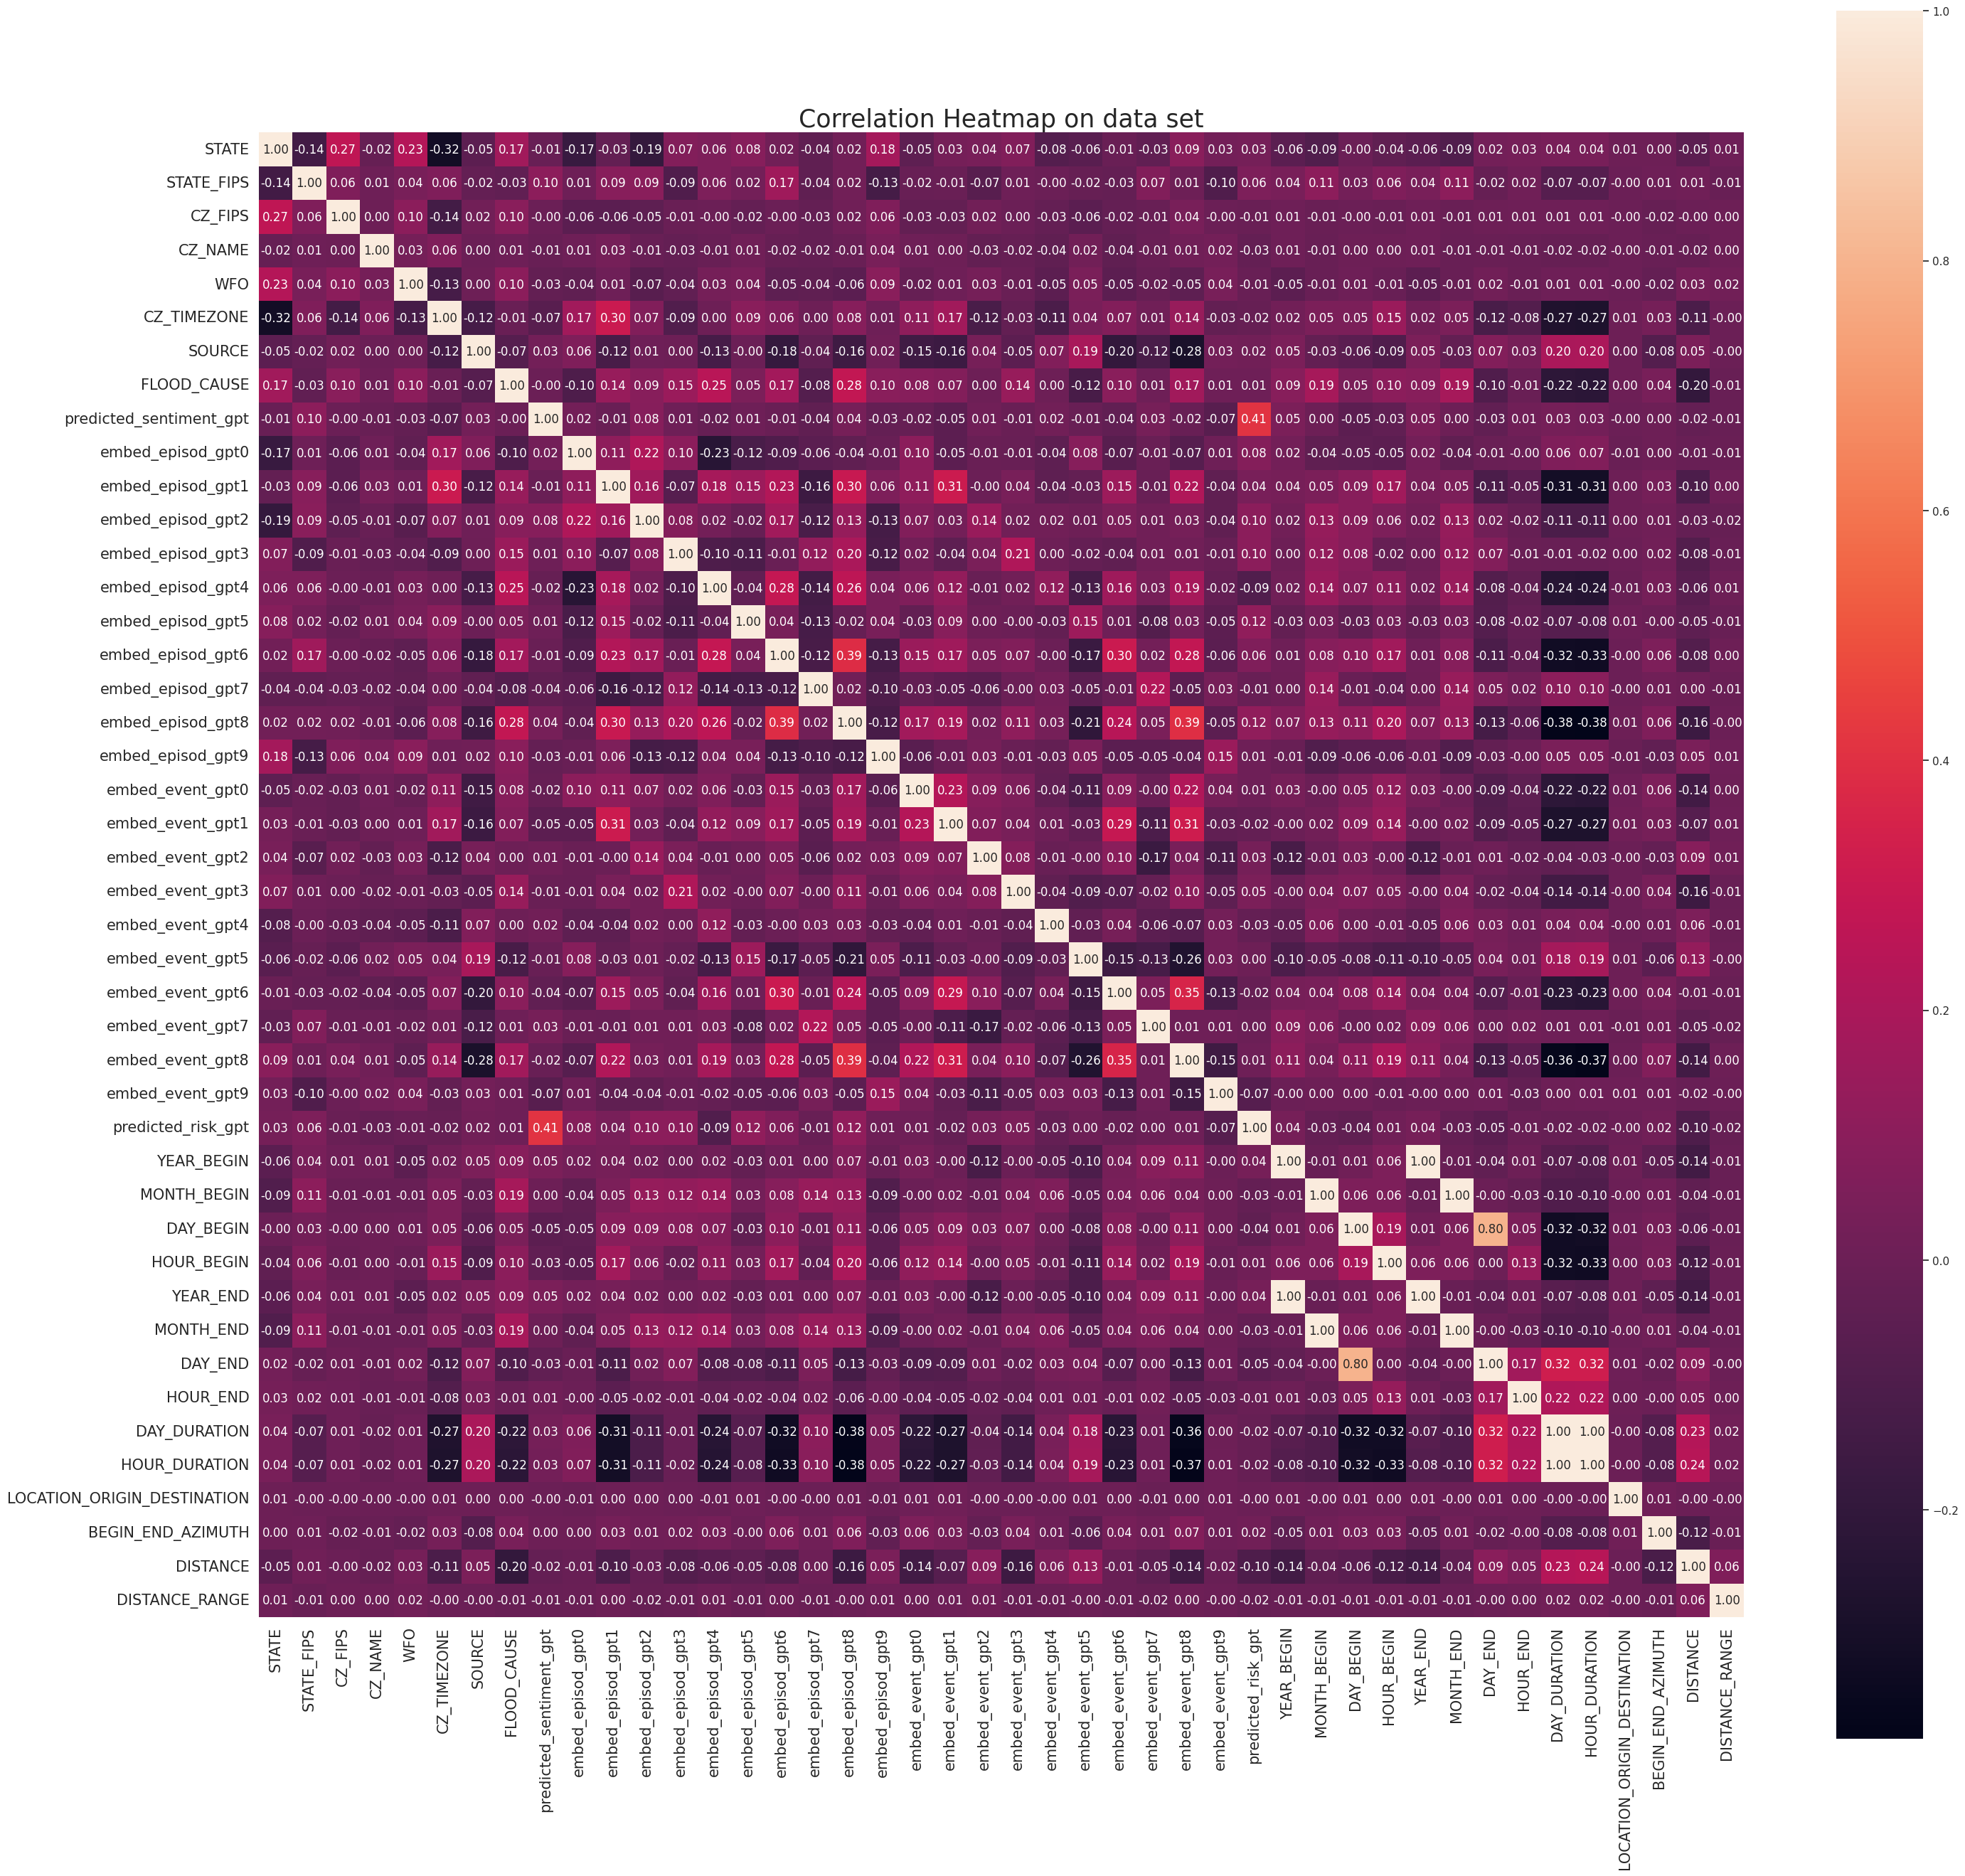

In [49]:
# Correlation heatmap
corr_matrix = X_all.corr()
sns.set( rc = {'figure.figsize': (30, 30)})
plt.figure()
sns.heatmap(corr_matrix, square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=25)
plt.yticks(fontsize="15")
plt.xticks(fontsize="15")
plt.show()

In [50]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['YEAR_END', 'MONTH_END', 'DAY_END', 'HOUR_DURATION']

In [51]:
# Drop features
X_all_f = X_all.drop(X_all[to_drop], axis=1)

In [52]:
# Look at the new features data set
X_all_f.shape

(38014, 40)

### Standardization

In [53]:
scaling=MinMaxScaler()

In [54]:
num1_ = ['STATE_FIPS',
'CZ_FIPS',
'YEAR_BEGIN',
'MONTH_BEGIN',
'DAY_BEGIN',
'HOUR_BEGIN',
'HOUR_END',
'DAY_DURATION',
'DISTANCE',
'DISTANCE_RANGE']

In [55]:
num2_=['embed_episod_gpt0',
'embed_episod_gpt1',
'embed_episod_gpt2',
'embed_episod_gpt3',
'embed_episod_gpt4',
'embed_episod_gpt5',
'embed_episod_gpt6',
'embed_episod_gpt7',
'embed_episod_gpt8',
'embed_episod_gpt9',
'embed_event_gpt0',
'embed_event_gpt1',
'embed_event_gpt2',
'embed_event_gpt3',
'embed_event_gpt4',
'embed_event_gpt5',
'embed_event_gpt6',
'embed_event_gpt7',
'embed_event_gpt8',
'embed_event_gpt9']

In [56]:
cat_=['STATE',
'CZ_NAME',
'WFO',
'CZ_TIMEZONE',
'SOURCE',
'FLOOD_CAUSE',
'BEGIN_END_AZIMUTH',
'LOCATION_ORIGIN_DESTINATION',
'predicted_sentiment_gpt',
'predicted_risk_gpt']

In [57]:
cat_new=X_all_f[cat_]
num1_new=X_all_f[num1_]
num2_new=X_all_f[num2_]

In [58]:
# Features to scale
num_sc=pd.DataFrame(scaling.fit_transform(num1_new),
columns = ['STATE_FIPS',
'CZ_FIPS',
'YEAR_BEGIN',
'MONTH_BEGIN',
'DAY_BEGIN',
'HOUR_BEGIN',
'HOUR_END',
'DAY_DURATION',
'DISTANCE',
'DISTANCE_RANGE'], index=cat_new.index)

In [59]:
# New features scaled data set
X_all_sc = pd.concat([cat_new, num_sc, num2_new],axis='columns')

### Feature Engineering with Lag and Rolling Window Features

In [60]:
# Lag Features function
def lag_feat(df, var):
  df_lag = df.copy()  # Create a copy of the original dataframe
  lags = [1,7,30,90, 180, 270, 365]  # 1 day, 7 days, 1 month, 3 months, 6 months, 9 months, 1 year
  outcomes = [var]
  df_lag=df_lag.assign(**{
      f'{col} (t-{lag})': df_lag[col].shift(lag)
      for lag in lags
      for col in outcomes})
  # Remove nan values
  df_lag = df_lag.dropna()
  return df_lag

In [61]:
# Rolling features function
def win_feat(df_lag, var):
  windows = [7, 30]  # 7 days, 1 month
  outcomes = [var]
  df_lag_win = df_lag.copy()
  for window in windows:
    for col in outcomes:
        df_lag_win[f"{col} (r_w-{window}) mean"] = df_lag_win[col].rolling(window=window).mean()
  # Remove nan values
  df_lag_win = df_lag_win.dropna()
  return df_lag_win


In [62]:
all = pd.concat([target, X_all_f], axis=1)
all_sc = pd.concat([target, X_all_sc], axis=1)


In [63]:
all_lag=lag_feat(all, 'DEATHS_DIRECT')
all_lag_win=win_feat(all_lag, 'DEATHS_DIRECT')
all_lag_sc=lag_feat(all_sc, 'DEATHS_DIRECT')
all_lag_win_sc=win_feat(all_lag_sc, 'DEATHS_DIRECT')

### Split data set

In [64]:
# Attach Target variable
# Split data set train/test set : test set is built on the last year
train = all_lag_win[all_lag_win.index < '2022-01-01']
test = all_lag_win[all_lag_win.index >= '2022-01-01']
len(train), len(test)

(35727, 1893)

In [65]:
# Attach Target variable
# Split data set train/test set : test set is built on the last year
train_sc = all_lag_win_sc[all_lag_win_sc.index < '2022-01-01']
test_sc = all_lag_win_sc[all_lag_win_sc.index >= '2022-01-01']
len(train_sc), len(test_sc)

(35727, 1893)

In [66]:
# split target and features
X_train = train.copy()
y_train = np.log1p(X_train.DEATHS_DIRECT)
y_train = pd.DataFrame(X_train, columns=['DEATHS_DIRECT'])
X_train.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
X_test = test.copy()
y_test = np.log1p(X_test.DEATHS_DIRECT)
y_test = pd.DataFrame(X_test, columns=['DEATHS_DIRECT'])
X_test.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
X_train_sc = train_sc.copy()
X_train_sc.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
X_test_sc = test_sc.copy()
X_test_sc.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
train_exposure = np.full(X_train.shape[0], 1)
test_exposure = np.full(X_test.shape[0], 1)
train_exposure_df = pd.DataFrame(train_exposure, index=y_train.index, columns=['EXPOSURE'])
test_exposure_df = pd.DataFrame(test_exposure, index=y_test.index,columns=['EXPOSURE'])
train_df = train.copy()
test_df = test.copy()




### Modelling & Evaluation

### Naive

### Fit & Prediction

In [67]:
y_train_=y_train.copy()
y_test_=y_test.copy()
y_train_['DEATHS_DIRECT_naive'] = y_train_['DEATHS_DIRECT'].shift(1)
y_test_['DEATHS_DIRECT_naive'] = y_test_['DEATHS_DIRECT'].shift(1)
predictions_tr = y_train_.drop(columns="DEATHS_DIRECT")
predictions_te = y_test_.drop(columns="DEATHS_DIRECT")
rmse_train = np.sqrt(mean_squared_error(y_train_.iloc[1:,0], predictions_tr.iloc[1:,0]))
rmse_test = np.sqrt(mean_squared_error(y_test_.iloc[1:,0], predictions_te.iloc[1:,0]))
mae_train = mean_absolute_error(y_train_.iloc[1:,0], predictions_tr.iloc[1:,0])
mae_test = mean_absolute_error(y_test_.iloc[1:,0], predictions_te.iloc[1:,0])
#mpd_train = mean_poisson_deviance(y_train.iloc[1:,0], predictions_tr.iloc[1:,0])
#mpd_test = mean_poisson_deviance(y_test.iloc[1:,0], predictions_te.iloc[1:,0])


score_naive = []
score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': 'N/A',
        'mpd_test': 'N/A'
}

score_naive.append(score_dict)
score_naive = pd.DataFrame(score_naive, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_naive = np.expm1(predictions_tr).copy()
predictions_te_naive = np.expm1(predictions_te).copy()
train_df = pd.concat([train_df, predictions_tr_naive.set_index(train_df.index)], axis=1)
test_df = pd.concat([test_df, predictions_te_naive.set_index(test_df.index)], axis=1)

### Evaluation

In [68]:
naive_results = {'model':['naive'],
               'rmse_train':score_naive['rmse_train'],
               'rmse_test': score_naive['rmse_test'],
              'mae_train': score_naive['mae_train'],
              'mae_test': score_naive['mae_test'],
              'mpd_train': score_naive['mpd_train'],
              'mpd_test': score_naive['mpd_test']
                 }
score_naive = pd.DataFrame(naive_results,
                         columns=['model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_naive

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,naive,0.133634,0.145402,0.013827,0.012685,N/A,N/A


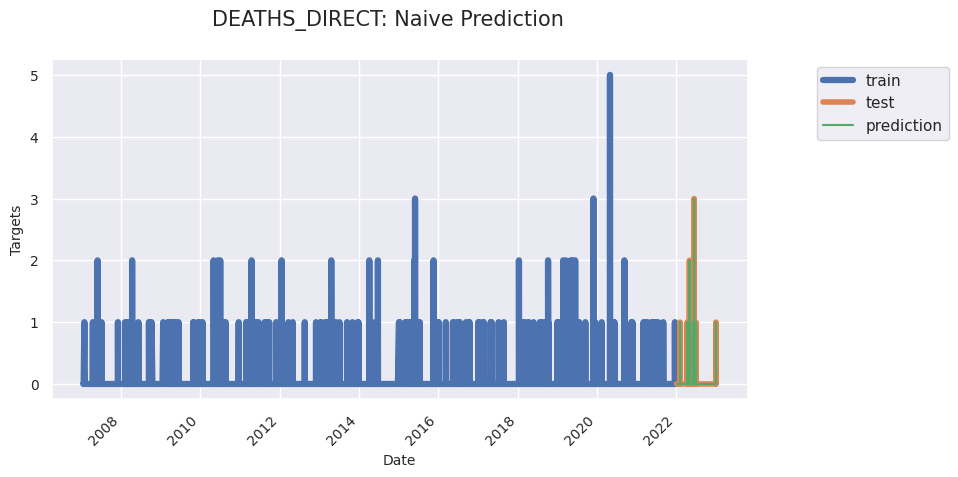

In [69]:
fig, ax = plt.subplots(figsize=(8, 5))
y_train_['DEATHS_DIRECT'].plot(ax=ax, label='train',linewidth=4.5)
y_test_['DEATHS_DIRECT'].plot(ax=ax, label='test',linewidth=4)
y_test_['DEATHS_DIRECT_naive'].plot(ax=ax, label='prediction')
plt.suptitle('DEATHS_DIRECT: Naive Prediction', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
ax.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

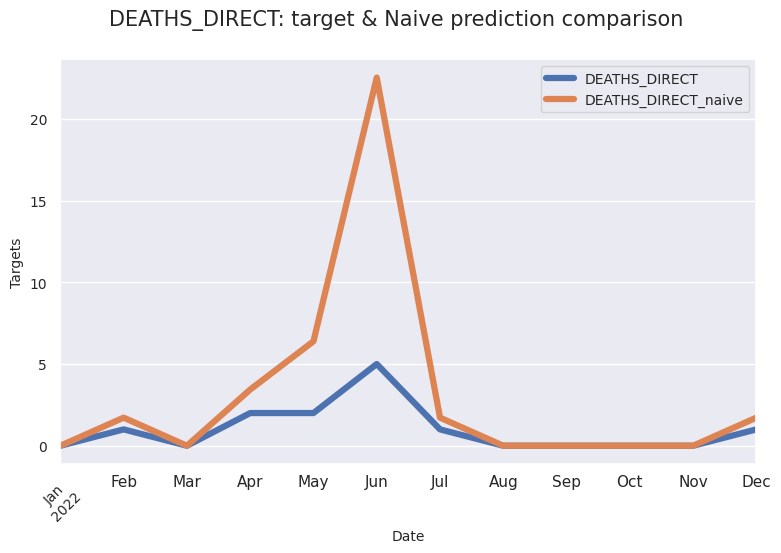

In [70]:
# Plot results
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'DEATHS_DIRECT': 'sum',
    'DEATHS_DIRECT_naive': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('DEATHS_DIRECT: target & Naive prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

### GLM

#### Fine-Tuning

In [71]:
#def objective(trial):
#    params = {
#        'power': trial.suggest_loguniform('power', 1, 1.5),
#        'link':'log'
#    }
#    np.random.seed(0)
#    glm = TweedieRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)
#    mpd_scores = []

#    for train_index, val_index in tscv.split(X_train):
#        X_tr, X_val, tr_exposure, val_exposure = X_train.iloc[train_index], X_train.iloc[val_index], train_exposure[train_index], train_exposure[val_index]
#        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

#        glm.fit(X_tr, y_tr.squeeze()/tr_exposure, sample_weight=tr_exposure)
#        pred_val = glm.predict(X_val)

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params


In [72]:
#best_params

### Fit & Prediction

In [73]:
np.random.seed(0)
glm_tuned = TweedieRegressor(power=1.195621280954126, link='log') # GLM with compound Poisson-Gamma distribution
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
glm_model = GridSearchCV(glm_tuned,param_grid,cv=tscv)
glm_model=glm_model.fit(X_train_sc, y_train.squeeze()/train_exposure,sample_weight=train_exposure)
score_glm = []
predictions_tr = glm_model.predict(X_train_sc)
predictions_te = glm_model.predict(X_test_sc)
rmse_train = np.sqrt(mean_squared_error(y_train.squeeze()/train_exposure, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze()/test_exposure, predictions_te))
mae_train = mean_absolute_error(y_train.squeeze()/train_exposure, predictions_tr)
mae_test = mean_absolute_error(y_test.squeeze()/test_exposure, predictions_te)
mpd_train = mean_poisson_deviance(y_train.squeeze()/train_exposure, predictions_tr)
mpd_test = mean_poisson_deviance(y_test.squeeze()/test_exposure, predictions_te)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_glm.append(score_dict)
score_glm = pd.DataFrame(score_glm, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_glm = pd.DataFrame(np.expm1(predictions_tr*train_exposure), columns = ['DEATHS_DIRECT_predict_glm'])
predictions_te_glm = pd.DataFrame(np.expm1(predictions_te*test_exposure), columns = ['DEATHS_DIRECT_predict_glm'])
train_df = pd.concat([train_df, predictions_tr_glm.set_index(train_df.index)], axis=1)
test_df = pd.concat([test_df, predictions_te_glm.set_index(test_df.index)], axis=1)



### Evaluation

In [74]:
glm_results = {'model':['glm'],
               'rmse_train':score_glm['rmse_train'],
               'rmse_test': score_glm['rmse_test'],
              'mae_train': score_glm['mae_train'],
              'mae_test': score_glm['mae_test'],
               'mpd_train': score_glm['mpd_train'],
               'mpd_test': score_glm['mpd_test']
               }
score_glm = pd.DataFrame(glm_results,
                         columns=['model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_glm

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,glm,0.095674,0.102588,0.014247,0.013447,0.072883,0.069021


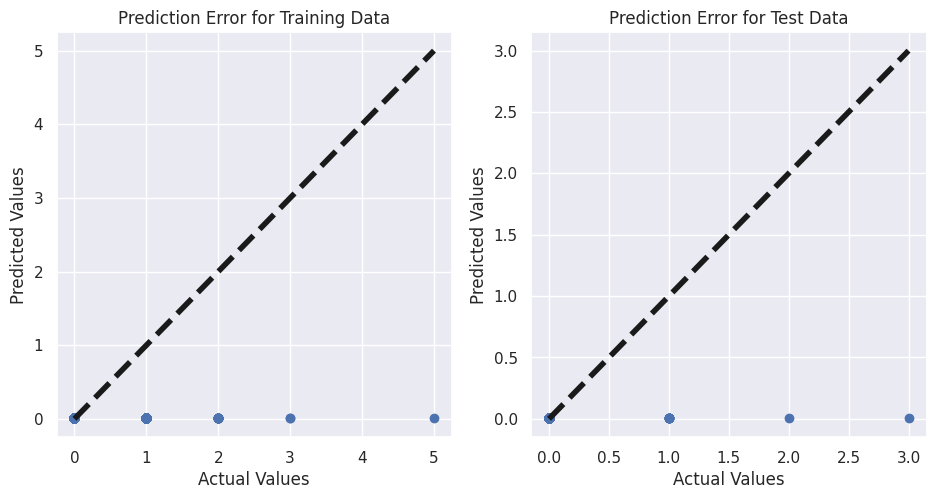

In [75]:
# Plot prediction error
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_tr)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
plt.title('Prediction Error for Training Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_te)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Prediction Error for Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


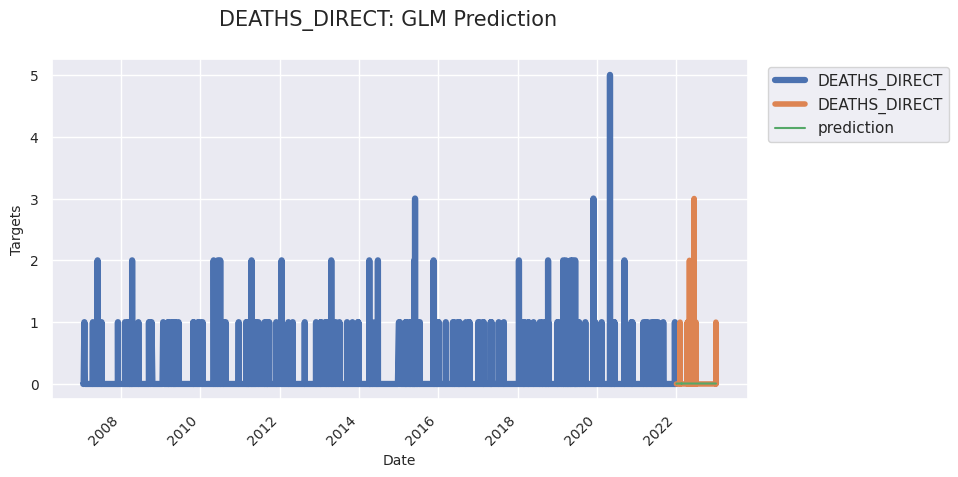

In [76]:
fig, ax = plt.subplots(figsize=(8, 5))
y_train.plot(ax=ax, label='train',linewidth=4.5)
y_test.plot(ax=ax, label='test',linewidth=4)
test_df['DEATHS_DIRECT_predict_glm'].plot(ax=ax, label='prediction')
plt.suptitle('DEATHS_DIRECT: GLM Prediction', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
ax.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

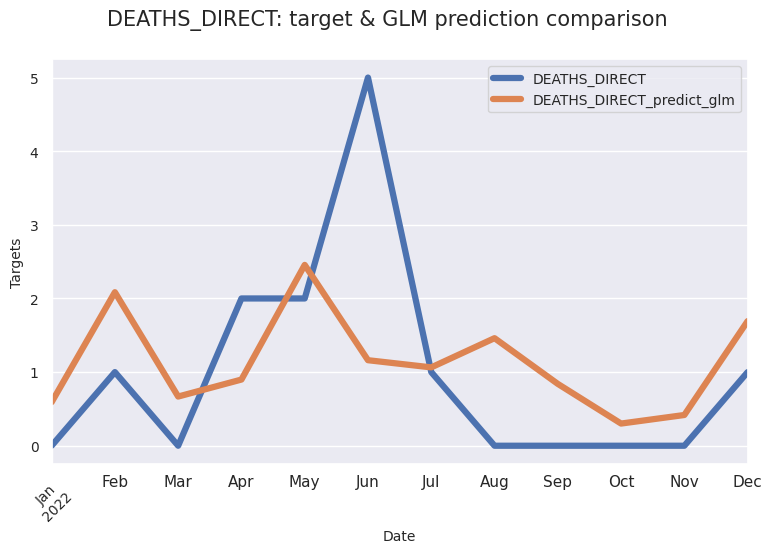

In [77]:
# Plot results
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'DEATHS_DIRECT': 'sum',
    'DEATHS_DIRECT_predict_glm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('DEATHS_DIRECT: target & GLM prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

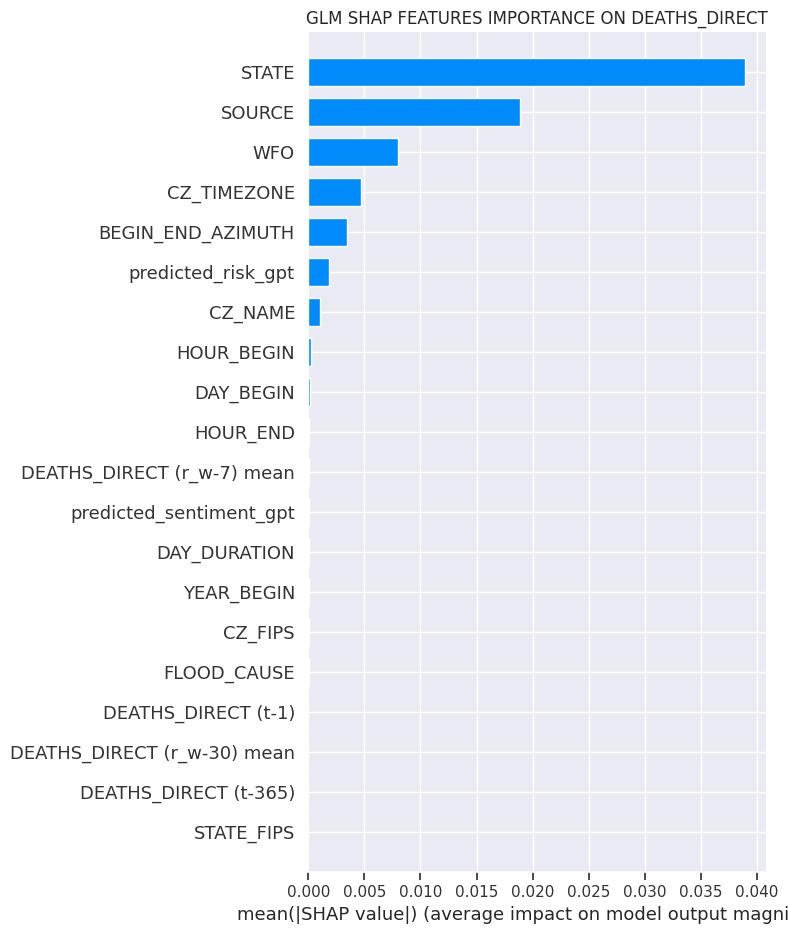

In [78]:
# Global SHAP on GLM
GLM_ = TweedieRegressor(power=1.195621280954126, link='log').fit(X_train_sc, y_train.squeeze()/train_exposure,sample_weight=train_exposure)
masker = shap.maskers.Independent(X_train_sc)
GLM_explainer = shap.LinearExplainer(GLM_, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test_sc)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON DEATHS_DIRECT")
shap.summary_plot(GLM_shap_values, features=X_test_sc, feature_names=X_test_sc.columns,plot_type='bar')




### LightGBM

#### Fine-tuning the model

In [79]:
# Fine-tuning

#def objective(trial):
#    params = {
#        'objective': 'poisson',
#        'random_state': 0,
#        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'max_depth': trial.suggest_int('max_depth', 3, 8),
#        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
#    }

#    lgbm = LGBMRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)

#    mpd_scores = []


#    for train_index, val_index in tscv.split(X_train):
#        X_tr, X_val, tr_exposure, val_exposure = X_train.iloc[train_index], X_train.iloc[val_index], train_exposure[train_index],train_exposure[val_index]
#        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

#        lgbm.fit(X_tr, y_tr.squeeze()/tr_exposure, sample_weight=tr_exposure)
#        pred_val = lgbm.predict(X_val)

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)

#best_params = study.best_params



In [80]:
#best_params

#### Fit & Prediction

In [81]:
lgbm_tuned =  LGBMRegressor(
    n_estimators= 405,
    learning_rate= 0.022470929282511067,
    max_depth= 3,
    num_leaves= 42,
    min_child_samples= 60,
    objective='poisson',
    random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
lgbm_model = GridSearchCV(lgbm_tuned,param_grid,cv=tscv)
lgbm_model.fit(X_train, y_train.squeeze()/train_exposure, sample_weight=train_exposure)
score_lgbm=[]
predictions_tr = lgbm_model.predict(X_train)
predictions_te = lgbm_model.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train.squeeze()/train_exposure, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze()/test_exposure, predictions_te))
mae_train = mean_absolute_error(y_train.squeeze()/train_exposure, predictions_tr)
mae_test = mean_absolute_error(y_test.squeeze()/test_exposure, predictions_te)
mpd_train = mean_poisson_deviance(y_train.squeeze()/train_exposure, predictions_tr)
mpd_test = mean_poisson_deviance(y_test.squeeze()/test_exposure, predictions_te)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_lgbm.append(score_dict)
score_lgbm = pd.DataFrame(score_lgbm, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_lgbm = pd.DataFrame(np.expm1(predictions_tr*train_exposure), columns = ['DEATHS_DIRECT_predict_lgbm'])
predictions_te_lgbm = pd.DataFrame(np.expm1(predictions_te*test_exposure), columns = ['DEATHS_DIRECT_predict_lgbm'])
train_df = pd.concat([train_df, predictions_tr_lgbm.set_index(train_df.index)], axis=1)
test_df = pd.concat([test_df, predictions_te_lgbm.set_index(test_df.index)], axis=1)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5788
[LightGBM] [Info] Number of data points in the train set: 5957, number of used features: 41
[LightGBM] [Info] Start training from score -5.108803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

### Evaluation

In [82]:
lgbm_results = {'model':['lgbm'],
               'rmse_train':score_lgbm['rmse_train'],
               'rmse_test': score_lgbm['rmse_test'],
              'mae_train': score_lgbm['mae_train'],
              'mae_test': score_lgbm['mae_test'],
              'mpd_train': score_lgbm['mpd_train'],
              'mpd_test': score_lgbm['mpd_test']
               }
score_lgbm = pd.DataFrame(lgbm_results,
                         columns=['model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_lgbm

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,lgbm,0.062139,0.072221,0.007117,0.006793,0.0123,0.010878


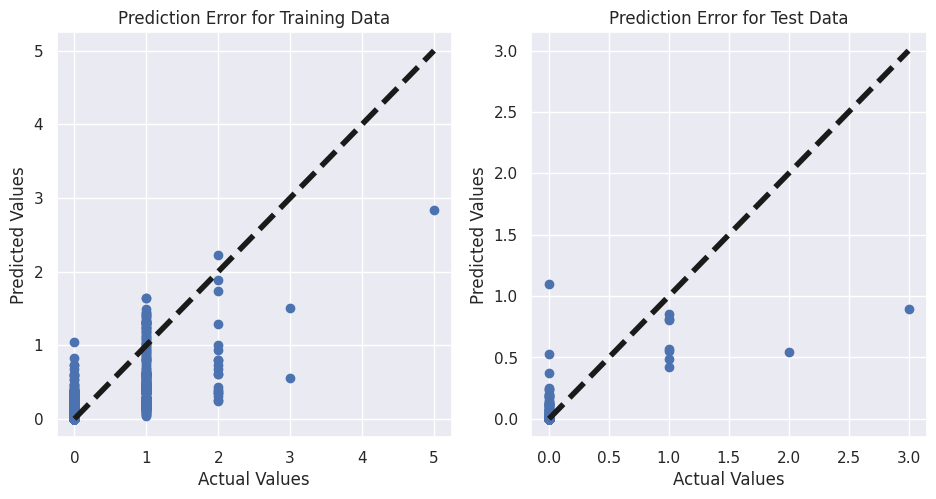

In [83]:
# Plot prediction error
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_tr)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
plt.title('Prediction Error for Training Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_te)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Prediction Error for Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


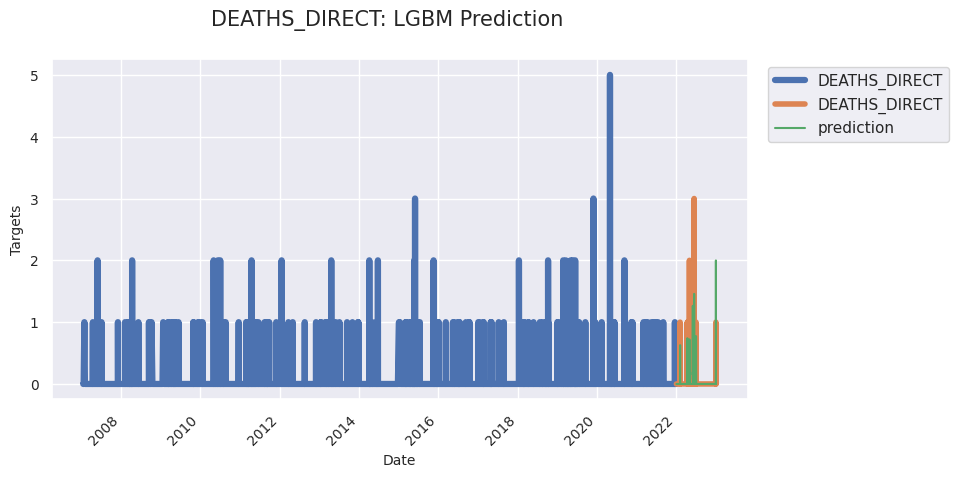

In [84]:
fig, ax = plt.subplots(figsize=(8, 5))
y_train.plot(ax=ax, label='train',linewidth=4.5)
y_test.plot(ax=ax, label='test',linewidth=4)
test_df['DEATHS_DIRECT_predict_lgbm'].plot(ax=ax, label='prediction')
plt.suptitle('DEATHS_DIRECT: LGBM Prediction', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
ax.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

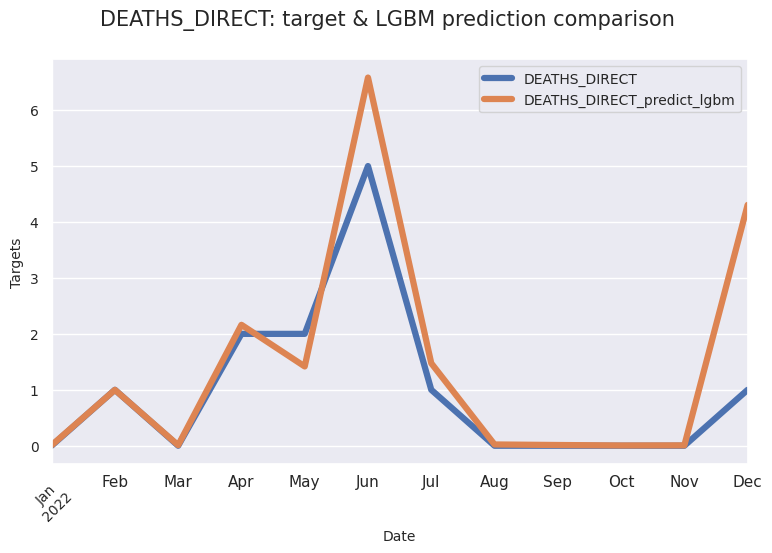

In [85]:
# Plot results
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'DEATHS_DIRECT': 'sum',
    'DEATHS_DIRECT_predict_lgbm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('DEATHS_DIRECT: target & LGBM prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 35727, number of used features: 48
[LightGBM] [Info] Start training from score -4.934586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

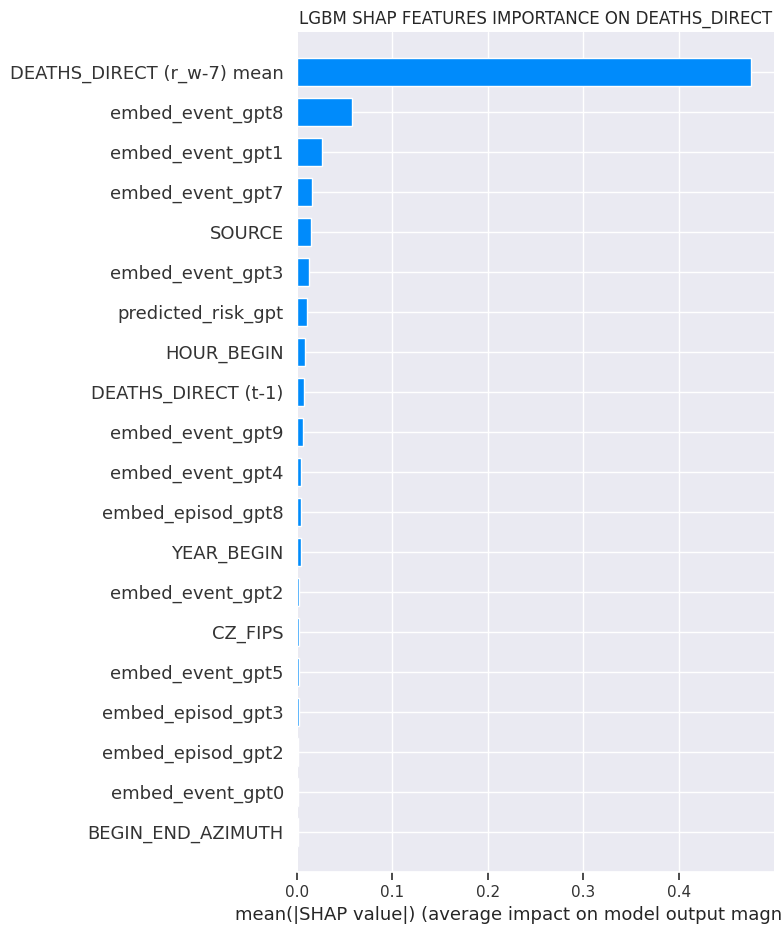

In [86]:
# Global SHAP on LGBM
LGBM_ = LGBMRegressor(
n_estimators= 405,
    learning_rate= 0.022470929282511067,
    max_depth= 3,
    num_leaves= 42,
    min_child_samples= 60,
    objective='poisson',
    random_state=0).fit(X_train, y_train.squeeze()/train_exposure, sample_weight=train_exposure)
LGBM_explainer = shap.TreeExplainer(LGBM_)
LGBM_shap_values = LGBM_explainer.shap_values(X_test)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("LGBM SHAP FEATURES IMPORTANCE ON DEATHS_DIRECT")
shap.summary_plot(LGBM_shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar')

### NN

#### Fine-tuning the model

In [87]:
# fine-tuning
#def objective(trial):
#    params = {
#        'hidden_layer_sizes': (trial.suggest_int('n_neurons_1', 10, 500), trial.suggest_int('n_neurons_2', 10, 500), trial.suggest_int('n_neurons_3', 10, 500)),
#        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e2),
#        'learning_rate_init': trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-2),
#        'max_iter': trial.suggest_int('max_iter', 10, 500),
#        'random_state': 0,
#        'activation':'relu'
#    }

#    mlp = MLPRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)
#    mpd_scores = []

#    X_train_sc_ = pd.concat([X_train_sc, train_exposure_df], axis=1)


#    for train_index, val_index in tscv.split(X_train_sc_):
#        X_tr, X_val, tr_exposure, val_exposure = X_train_sc_.iloc[train_index], X_train_sc_.iloc[val_index], train_exposure[train_index], train_exposure[val_index]
#        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

#        mlp.fit(X_tr, y_tr.squeeze()/tr_exposure)
#        pred_val = mlp.predict(X_val)

#        pred_val = np.maximum(pred_val, 1e-12) # Ensure predictions are strictly positive

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params

In [88]:
#best_params

#### Fit & Prediction

In [89]:
X_train_sc_ = pd.concat([X_train_sc, train_exposure_df], axis=1)
X_test_sc_ = pd.concat([X_test_sc, test_exposure_df], axis=1)


nn_tuned =  MLPRegressor(
hidden_layer_sizes= (105,473,61),
activation= 'relu',
alpha= 0.0003916489753672582,
learning_rate_init=0.006773978487063503,
max_iter=164,
random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
nn_model = GridSearchCV(nn_tuned,param_grid,cv=tscv)
nn_model.fit(X_train_sc_, y_train.squeeze()/train_exposure)
score_nn=[]
predictions_tr = np.maximum(nn_model.predict(X_train_sc_), 1e-12)
predictions_te = np.maximum(nn_model.predict(X_test_sc_),1e-12)
rmse_train = np.sqrt(mean_squared_error(y_train.squeeze()/train_exposure, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze()/test_exposure, predictions_te))
mae_train = mean_absolute_error(y_train.squeeze()/train_exposure, predictions_tr)
mae_test = mean_absolute_error(y_test.squeeze()/test_exposure, predictions_te)
mpd_train = mean_poisson_deviance(y_train.squeeze()/train_exposure, predictions_tr)
mpd_test = mean_poisson_deviance(y_test.squeeze()/test_exposure, predictions_te)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_nn.append(score_dict)
score_nn = pd.DataFrame(score_nn, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_nn = pd.DataFrame(np.expm1(predictions_tr*train_exposure), columns = ['DEATHS_DIRECT_predict_nn'])
predictions_te_nn = pd.DataFrame(np.expm1(predictions_te*test_exposure), columns = ['DEATHS_DIRECT_predict_nn'])
train_df = pd.concat([train_df, predictions_tr_nn.set_index(train_df.index)], axis=1)
test_df = pd.concat([test_df, predictions_te_nn.set_index(test_df.index)], axis=1)


### Evaluation

In [90]:
nn_results = {'model':['nn'],
               'rmse_train':score_nn['rmse_train'],
               'rmse_test': score_nn['rmse_test'],
              'mae_train': score_nn['mae_train'],
              'mae_test': score_nn['mae_test'],
              'mpd_train': score_nn['mpd_train'],
              'mpd_test': score_nn['mpd_test']
               }
score_nn = pd.DataFrame(nn_results,
                         columns=['model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_nn

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,nn,0.061617,0.084333,0.006894,0.008229,0.014607,0.018533


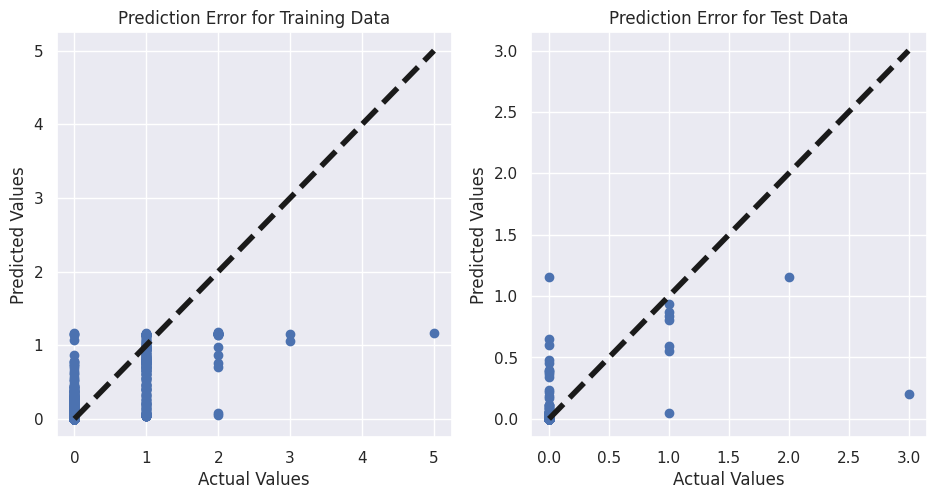

In [91]:
# Plot prediction error
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_tr)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
plt.title('Prediction Error for Training Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_te)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Prediction Error for Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


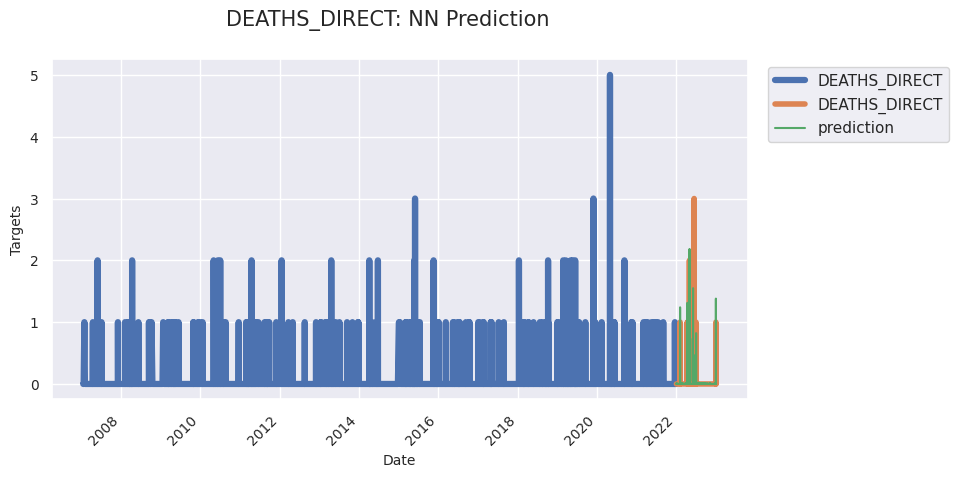

In [92]:
fig, ax = plt.subplots(figsize=(8, 5))
y_train.plot(ax=ax, label='train',linewidth=4.5)
y_test.plot(ax=ax, label='test',linewidth=4)
test_df['DEATHS_DIRECT_predict_nn'].plot(ax=ax, label='prediction')
plt.suptitle('DEATHS_DIRECT: NN Prediction', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
ax.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

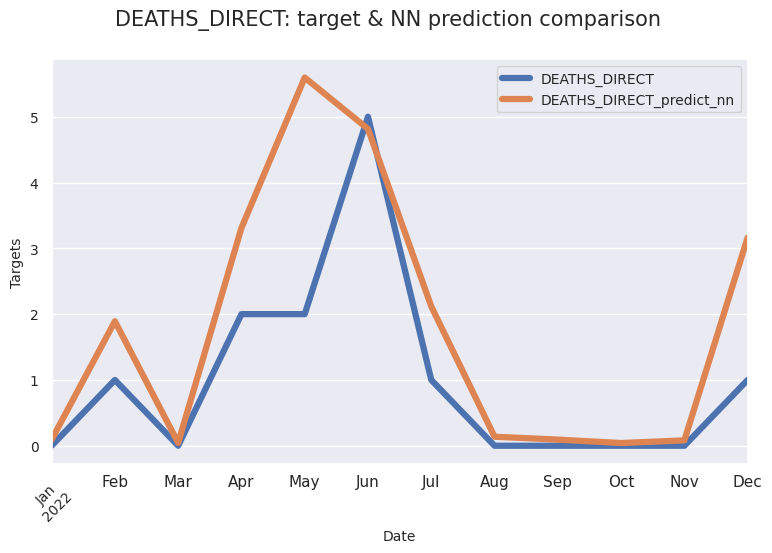

In [93]:
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'DEATHS_DIRECT': 'sum',
    'DEATHS_DIRECT_predict_nn': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('DEATHS_DIRECT: target & NN prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

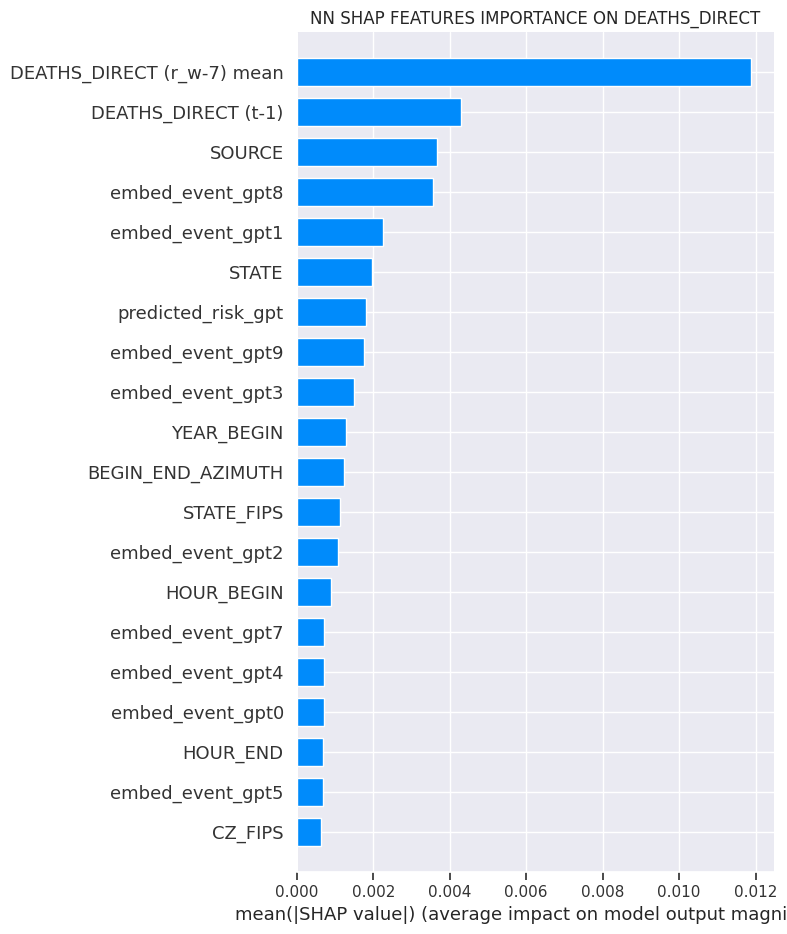

In [94]:
# Global SHAP on NN
NN_ = MLPRegressor(
hidden_layer_sizes= (105,473,61),
activation= 'relu',
alpha= 0.0003916489753672582,
learning_rate_init=0.006773978487063503,
max_iter=164,
random_state=0).fit(X_train_sc_, y_train.squeeze()/train_exposure)

# Choose 100 random samples from train and test
train_sample_indices = np.random.choice(len(X_train_sc_), 100, replace=False)
test_sample_indices = np.random.choice(len(X_test_sc_), 100, replace=False)

NN_explainer = shap.KernelExplainer(NN_.predict, X_train_sc_.iloc[train_sample_indices])
NN_shap_values = NN_explainer.shap_values(X_test_sc_.iloc[test_sample_indices])
plt.rcParams['figure.figsize'] = (5,5)
plt.title("NN SHAP FEATURES IMPORTANCE ON DEATHS_DIRECT")
shap.summary_plot(NN_shap_values, features=X_test_sc_.iloc[test_sample_indices], feature_names=X_test_sc_.columns, plot_type='bar')

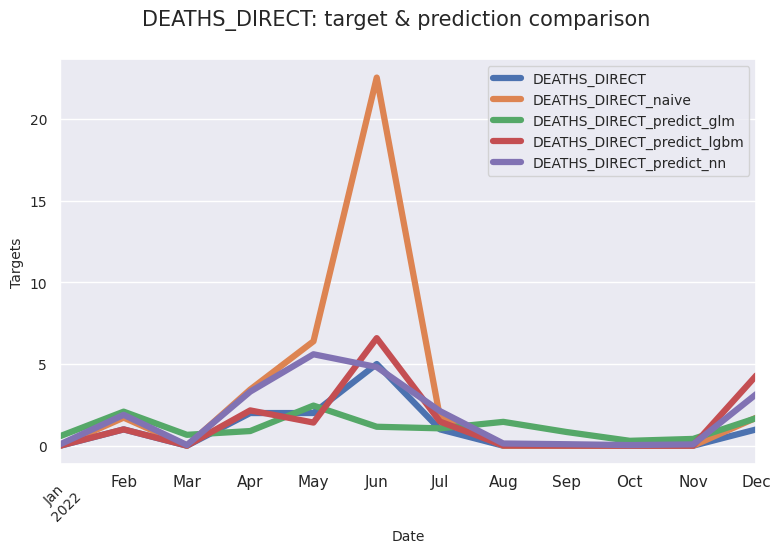

In [95]:
# plot all models
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'DEATHS_DIRECT': 'sum',
    'DEATHS_DIRECT_naive': 'sum',
    'DEATHS_DIRECT_predict_glm': 'sum',
    'DEATHS_DIRECT_predict_lgbm': 'sum',
    'DEATHS_DIRECT_predict_nn': 'sum'
    })
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('DEATHS_DIRECT: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [96]:
# total score
score = pd.concat([score_naive, score_glm, score_lgbm, score_nn])
score

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,naive,0.133634,0.145402,0.013827,0.012685,N/A,N/A
0,glm,0.095674,0.102588,0.014247,0.013447,0.072883,0.069021
0,lgbm,0.062139,0.072221,0.007117,0.006793,0.0123,0.010878
0,nn,0.061617,0.084333,0.006894,0.008229,0.014607,0.018533


#### Plot score results

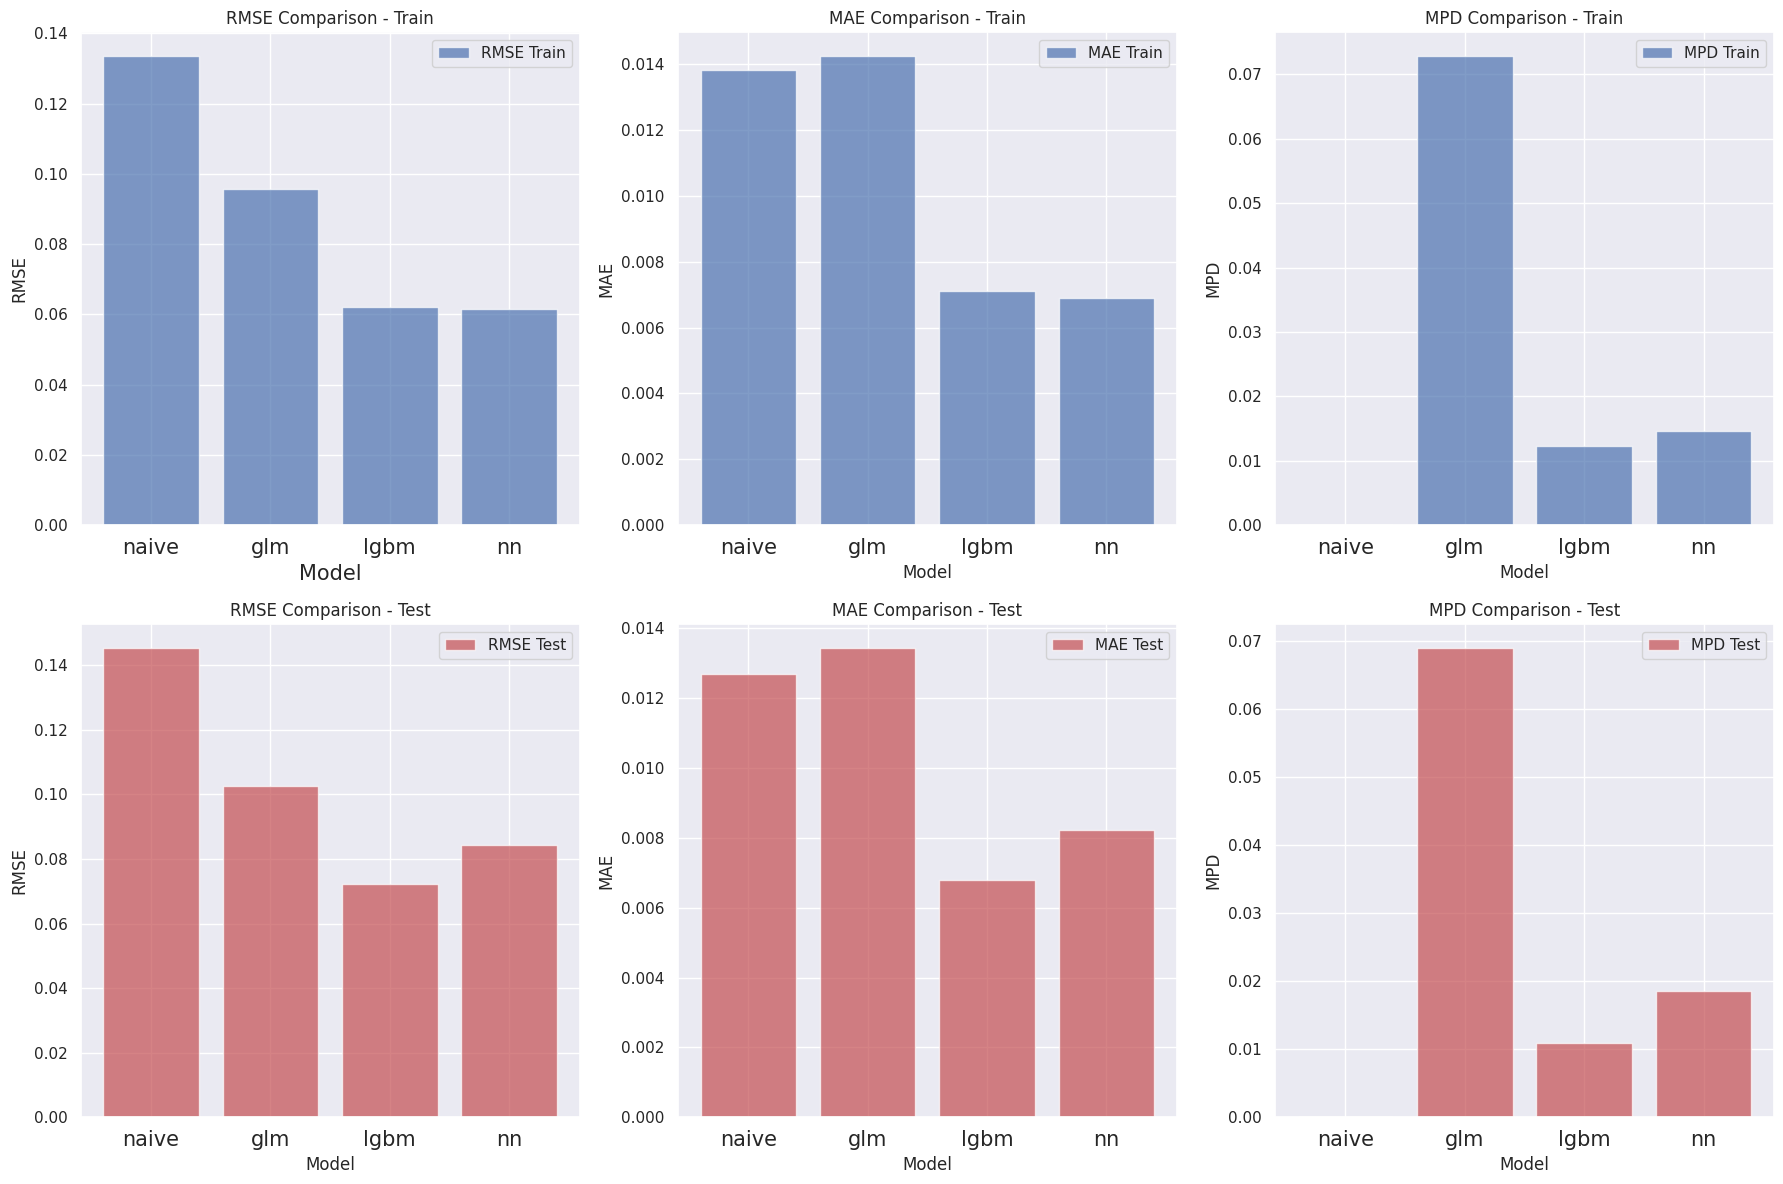

In [97]:
# Reset the index of the DataFrame
score = score.reset_index(drop=True)

# Replace 'N/A' with 0 only for the 'naive' row
score.loc[score['model'] == 'naive', ['mpd_train', 'mpd_test']] = score.loc[score['model'] == 'naive', ['mpd_train', 'mpd_test']].replace('N/A', 0)

# Convert 'mpd_train' and 'mpd_test' to float type
score['mpd_train'] = score['mpd_train'].astype(float)
score['mpd_test'] = score['mpd_test'].astype(float)

# Plotting 6 charts with 3 per row
plt.figure(figsize=(18, 12))

# Plot RMSE comparison for Train and Test
plt.subplot(2, 3, 1)
plt.bar(score['model'], score['rmse_train'], color='b', alpha=0.7, label='RMSE Train')
plt.xlabel('Model',fontsize=15)
plt.ylabel('RMSE')
plt.xticks(fontsize=15)
plt.legend()
plt.title('RMSE Comparison - Train')

plt.subplot(2, 3, 4)
plt.bar(score['model'], score['rmse_test'], color='r', alpha=0.7, label='RMSE Test')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(fontsize=15)
plt.legend()
plt.title('RMSE Comparison - Test')

# Plot MAE comparison for Train and Test
plt.subplot(2, 3, 2)
plt.bar(score['model'], score['mae_train'], color='b', alpha=0.7, label='MAE Train')
plt.xlabel('Model')
plt.xticks(fontsize=15)
plt.ylabel('MAE')
plt.legend()
plt.title('MAE Comparison - Train')

plt.subplot(2, 3, 5)
plt.bar(score['model'], score['mae_test'], color='r', alpha=0.7, label='MAE Test')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.xticks(fontsize=15)
plt.legend()
plt.title('MAE Comparison - Test')

# Plot MPD comparison for Train and Test
plt.subplot(2, 3, 3)
plt.bar(score['model'], score['mpd_train'], color='b', alpha=0.7, label='MPD Train')
plt.xlabel('Model')
plt.ylabel('MPD')
plt.xticks(fontsize=15)
plt.legend()
plt.title('MPD Comparison - Train')

plt.subplot(2, 3, 6)
plt.bar(score['model'], score['mpd_test'], color='r', alpha=0.7, label='MPD Test')
plt.xlabel('Model')
plt.ylabel('MPD')
plt.xticks(fontsize=15)
plt.legend()
plt.title('MPD Comparison - Test')

plt.tight_layout()
plt.show()